In [ ]:
%pip install earthengine-api

In [29]:
%matplotlib inline

In [5]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [6]:
import ee

# Re-initialize just in case
ee.Initialize()

# Define the bounding box roughly over Siberia
siberia = ee.Geometry.Rectangle([60, 57, 140, 72])  # (lon_min, lat_min, lon_max, lat_max)

# Time range
start_date = '2013-01-01'
end_date = '2023-12-31'

In [8]:
# Load MODIS Albedo data
modis_albedo = ee.ImageCollection("MODIS/006/MCD43A3") \
    .filterDate(start_date, end_date) \
    .filterBounds(siberia)

# Print how many images were found
print("Number of images:", modis_albedo.size().getInfo())

Number of images: 3693


In [9]:
def summer_mean(year):
    start = ee.Date.fromYMD(year, 6, 1)
    end = ee.Date.fromYMD(year, 8, 31)
    summer = modis_albedo.filterDate(start, end)
    return summer.mean().set('year', year)

# Generate yearly summer means from 2000 to 2022
years = list(range(2000, 2023))
summer_means = ee.ImageCollection([summer_mean(y) for y in years])

In [10]:
# Stack all years for a linear regression trend analysis
def add_time(image):
    year = ee.Number(image.get('year'))
    return image.addBands(ee.Image.constant(year).rename('year')).select(['Albedo_BSA_Band1', 'year'])

with_time = summer_means.map(add_time)

# Perform linear regression
linear_fit = with_time.select(['year', 'Albedo_BSA_Band1']).reduce(ee.Reducer.linearFit())

In [13]:
def get_monthly_albedo(year, month, region):
    # Format month as '01', '02', etc.
    month_str = str(month).zfill(2)
    start = ee.Date(f"{year}-{month_str}-01")
    end = start.advance(1, 'month')

    collection = ee.ImageCollection("MODIS/006/MCD43A3") \
        .filterDate(start, end) \
        .filterBounds(region) \
        .select('Albedo_WSA_shortwave')

    monthly_mean = collection.mean().set({
        'year': year,
        'month': month,
        'label': 'snow' if month in [12, 1, 2] else 'leaf' if month in [6, 7, 8] else 'transition'
    })

    return monthly_mean

In [14]:
years = list(range(2001, 2021))
months = list(range(1, 13))

monthly_albedo_images = []

for year in years:
    for month in months:
        img = get_monthly_albedo(year, month, siberia)
        monthly_albedo_images.append(img)

# Create an image collection
monthly_albedo_ic = ee.ImageCollection(monthly_albedo_images)

In [15]:
task = ee.batch.Export.table.toDrive(
    collection=monthly_albedo_ic,
    description='Monthly_Albedo_Stats',
    fileFormat='CSV'
)
task.start()

In [17]:
import pandas as pd

df = pd.read_csv('Monthly_Albedo_Stats.csv')
df.head()

,system:index,label,month,system:band_names,system:bands,year,.geo
0,0,snow,1,[Albedo_WSA_shortwave],<Element>,2001,"{""type"":""Polygon"",""coordinates"":[[[-180.0,-90...."
1,1,snow,2,[Albedo_WSA_shortwave],<Element>,2001,"{""type"":""Polygon"",""coordinates"":[[[-180.0,-90...."
2,2,transition,3,[Albedo_WSA_shortwave],<Element>,2001,"{""type"":""Polygon"",""coordinates"":[[[-180.0,-90...."
3,3,transition,4,[Albedo_WSA_shortwave],<Element>,2001,"{""type"":""Polygon"",""coordinates"":[[[-180.0,-90...."
4,4,transition,5,[Albedo_WSA_shortwave],<Element>,2001,"{""type"":""Polygon"",""coordinates"":[[[-180.0,-90...."


In [ ]:
# Make sure 'label', 'year', and 'mean' exist
df['year'] = df['year'].astype(int)
df['label'] = df['label'].astype(str)

# Group by year and season label
seasonal_means = df.groupby(['year', 'label'])['mean'].mean().unstack()
seasonal_means.plot(kind='line', title='Seasonal Albedo Trends')

In [21]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'snow'
    elif month in [6, 7, 8]:
        return 'leaf'
    else:
        return 'transition'
def compute_mean_albedo(image):
    # Get image date info
    date = ee.Date(image.get('system:time_start'))
    year = date.get('year')
    month = date.get('month')
    
    # Reduce region to get mean albedo over Siberia
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=siberia,
        scale=500,
        maxPixels=1e13
    )
    
    # Add results as properties
    return ee.Feature(None, {
        'mean_albedo': mean_dict.get('Albedo_WSA_shortwave'),
        'year': year,
        'month': month,
        'season': get_season_from_month(month)
    })
def get_season_from_month(month):
    # This wraps our Python logic into EE expression logic
    return ee.Algorithms.If(
        ee.Number(month).eq(12).Or(ee.Number(month).lte(2)), 'snow',
        ee.Algorithms.If(
            ee.Number(month).gte(6).And(ee.Number(month).lte(8)), 'leaf',
            'transition'
        )
    )
features = modis_albedo.map(compute_mean_albedo)
task = ee.batch.Export.table.toDrive(
    collection=features,
    description='Siberia_Monthly_Albedo',
    fileFormat='CSV'
)
task.start()

In [23]:
import pandas as pd

df = pd.read_csv("Siberia_Albedo_Seasonal.csv")  # Replace with your actual filename

In [24]:
monthly_avg = df.groupby('month')['mean_albedo'].mean().reset_index()
print(monthly_avg)

    month  mean_albedo
0       1   372.990903
1       2   443.641769
2       3   536.164851
3       4   564.448584
4       5   441.922345
5       6   194.803019
6       7   128.950962
7       8   123.029697
8       9   143.176762
9      10   316.027574
10     11   342.409513
11     12   271.096920


In [25]:
seasonal_avg = df.groupby('season')['mean_albedo'].mean().reset_index()
print(seasonal_avg)

       season  mean_albedo
0        leaf   148.378789
1        snow   374.950901
2  transition   391.358490


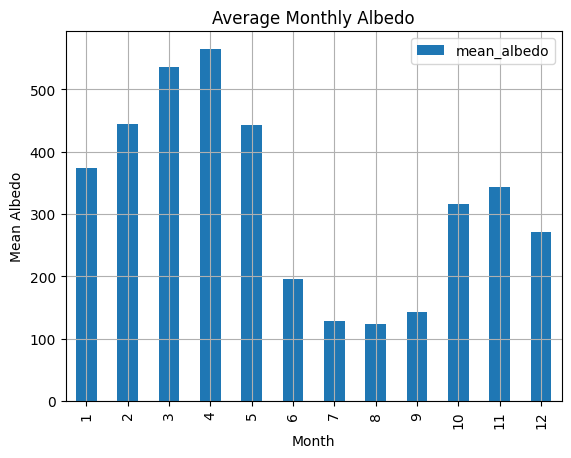

In [30]:
import matplotlib.pyplot as plt

monthly_avg.plot(x='month', y='mean_albedo', kind='bar')
plt.title('Average Monthly Albedo')
plt.xlabel('Month')
plt.ylabel('Mean Albedo')
plt.grid(True)
plt.show()